### Packages

In [1]:
import numpy as np
import csv
import string
import collections
import random
import pandas as pd
import plotnine as p9
import json

### Functions

In [2]:
def load_data(file):
    X_raw = []
    y = []

    with open(file, 'rt', encoding='utf8') as f:
        dict_reader = csv.DictReader(f)

        for observation in dict_reader:
            y.append(observation['gross_profit'])
            observation.pop('gross_profit', None)

            for key in ['store', 'longitude', 'latitude', 'city', 'county', 'liter', 'bottles', 'pop_city', 'fips', 'pop_county']:
                observation.pop(key, None)

            X_raw.append(observation)

    return X_raw, y

def convert_X_raw_to_array(X_raw):
    feature_keys = list(X_raw[0].keys())
    X = []

    for obs in X_raw:
        row = []

        for key in feature_keys:
            value = obs[key]
            row.append(value)

        X.append(row)

    return np.array(X)

def train_valid_test_split(X, y):
    random.seed(32)

    X_train = []
    X_valid = []
    X_test = []
    y_train = []
    y_valid = []
    y_test = []
   
    for index in range(len(X)):
        z = random.uniform(0, 1)

        if z < 0.7:
          X_train.append(X[index])
          y_train.append(y[index])

        elif z < 0.85:
            X_valid.append(X[index])
            y_valid.append(y[index])
            
        else:
            X_test.append(X[index])
            y_test.append(y[index])
                
    X_train = np.array(X_train, dtype=float)
    y_train = np.array(y_train, dtype=float)
    X_valid = np.array(X_valid, dtype=float)
    y_valid = np.array(y_valid, dtype=float)
    X_test = np.array(X_test, dtype=float)
    y_test = np.array(y_test, dtype=float)
    

    return X_train, X_valid, X_test, y_train, y_valid, y_test

def add_ones(X):
  beta_zero_column = np.ones((X.shape[0], 1))
  X_ones = np.hstack((beta_zero_column, X))

  return X_ones

def ols(X, y):
    X = X.astype(float)
    y = y.astype(float)

    # delete zero rows
    X = X[~np.all(X == 0, axis=1)]

    # delete zero columns
    X = X[:, ~np.all(X == 0, axis=0)]

    # ols
    Xt = X.transpose()
    Xt_X = np.dot(Xt, X)
    Xt_X_inv = np.linalg.pinv(Xt_X)
    Xt_X_inv_Xt = np.dot(Xt_X_inv, Xt)
    beta_hat = np.dot(Xt_X_inv_Xt, y)

    return beta_hat

def recenter(X, y):
    X = X - np.mean(X, 0)
    y = y - np.mean(y)

    return X, y

def ridge(X, y, fLambda):
    X = np.array(X)
    y = np.array(y)
    
    # delete zero rows
    # X = X[~np.all(X == 0, axis=1)]
    
    # # delete zero columns
    # X = X[:, ~np.all(X == 0, axis=0)]
    
    # ridge
    Xt = X.transpose()
    Xt_X = np.dot(Xt, X)
    lambda_I = fLambda * np.identity(X.shape[1])
    Xt_X_lambda_I_inv = np.linalg.inv(Xt_X + lambda_I)
    Xt_X_lambda_I_inv_Xt = np.dot(Xt_X_lambda_I_inv, Xt)
    beta_hat = np.dot(Xt_X_lambda_I_inv_Xt, y)

    return beta_hat

# new function to get the cols removed, got code from ols
def get_removed_col_indices(X):
    X = np.array(X)
    original_cols = np.arange(X.shape[1])
    non_zero_cols = ~np.all(X  == 0, axis=0)
    removed_cols = original_cols[~non_zero_cols]
    return removed_cols, original_cols

# new function to remove features
def remove_features(feat_list, removed_cols):
  return [feature for i, feature in enumerate(feat_list) if i not in removed_cols]

# prediction
def predict(X, beta):
  X = np.array(X)
  # X = X[:, ~np.all(X==0, axis=0)]
  beta = np.array(beta)
  y_hat = np.dot(X, beta)

  return y_hat

# calculate mse
def mean_squared_error(y_hat, y):
  mse = np.mean((y.flatten() - y_hat) ** 2)

  return mse

### Preparation

In [3]:
X_raw, y = load_data(file="data/iowa_without_month_item.csv")
y

['41723.39',
 '1031.32',
 '9583.2',
 '201153.76',
 '90997.87',
 '27548.19',
 '4460.900000000001',
 '6272.39',
 '7711.610000000001',
 '179777.31',
 '62869.39',
 '32238.1',
 '307005.22',
 '25378.25',
 '31913.27',
 '5440.01',
 '5793.85',
 '18105.82',
 '22841.61',
 '17811.010000000002',
 '100354.46',
 '70409.23',
 '1797.21',
 '4087.84',
 '83140.42',
 '81632.02',
 '99881.05',
 '35770.17',
 '96064.33',
 '14947.08',
 '127807.72',
 '6030.48',
 '8980.62',
 '2192711.03',
 '18012.43',
 '63218.25',
 '39951.39',
 '83164.67',
 '34349.87',
 '26914.69',
 '15193.44',
 '59056.3',
 '64307.53',
 '36624.79',
 '6988.6',
 '120853.62',
 '94653.11',
 '26202.78',
 '15109.05',
 '6957.11',
 '116420.22',
 '236049.03',
 '313919.48',
 '210809.87',
 '191112.97',
 '1596.02',
 '52415.85',
 '108024.82',
 '1720083.37',
 '62893.310000000005',
 '47402.25',
 '89117.27',
 '62098.39',
 '9381.99',
 '9181.67',
 '9693.59',
 '14236.57',
 '13282.07',
 '2028.75',
 '2685.38',
 '2935.13',
 '36462.97',
 '23433.61',
 '64736.12',
 '1184

In [4]:
X_raw[0]

{'cat_convenience_store': '0',
 'cat_distillery_brewery': '0',
 'cat_gas_station': '0',
 'cat_general_store': '0',
 'cat_grocery_store': '0',
 'cat_liquor_store_bar': '1',
 'cat_other': '0',
 'cat_pharmacy': '0',
 'cat_unknown': '0',
 'female_18_24': '351',
 'female_25_34': '445',
 'female_35_44': '464',
 'female_45_64': '1051',
 'female_65_over': '1093',
 'male_18_24': '406',
 'male_25_34': '491',
 'male_35_44': '571',
 'male_45_64': '1071',
 'male_65_over': '872',
 'annual_income': '65080',
 'excessive_drinking': '26',
 'gassale_x_gasstore': '0',
 'l_10th_mountain_american_single_malt': '0.0',
 'l_10th_mountain_bourbon': '0.0',
 'l_10th_mountain_brandy': '0.0',
 'l_10th_mountain_cordial': '0.0',
 'l_10th_mountain_rye': '0.0',
 'l_10th_mountain_vodka': '0.0',
 'l_135_east_hyogo_japanese_gin': '0.0',
 'l_15_stars_private_stock_8_and_15yr': '0.0',
 'l_173_craft_distillery_barrel_kane': '0.0',
 'l_173_craft_distillery_bourbon_whiskey': '0.0',
 'l_173_craft_distillery_broken_beaker_silver

In [5]:
X = convert_X_raw_to_array(X_raw)

In [164]:
X.shape

(2149, 4529)

In [6]:
X_train, X_valid, X_test, y_train, y_valid, y_test = train_valid_test_split(X, y)

In [172]:
print(X_train.shape)
print(y_train.shape[0])

(1486, 4529)
1486


In [173]:
print(X_test.shape)
print(y_test.shape[0])

(326, 4529)
326


In [174]:
print(X_valid.shape)
print(y_valid.shape[0])

(337, 4529)
337


# Redge Regression

In [7]:
df = pd.read_csv('data/iowa_without_month_item.csv')
df['gross_profit'].describe()

count    2.149000e+03
mean     6.933665e+04
std      1.986963e+05
min      2.100000e+01
25%      1.379814e+04
50%      2.499858e+04
75%      6.057135e+04
max      4.809150e+06
Name: gross_profit, dtype: float64

## 1. Training Data

In [13]:
X_train, y_train = recenter(X_train, y_train)
beta_hat_1 = ridge(X_train, y_train, fLambda=1)
feat_list = list(X_raw[0].keys())
feat = np.array(feat_list)
beta_hat_1_labeled = np.column_stack((feat, beta_hat_1))
beta_hat_1_labeled_dict = {str(row[0]): float(row[1]) for row in beta_hat_1_labeled}

with open('json/beta_hat_1_labeled.json', 'w') as f:
    json.dump(beta_hat_1_labeled_dict, f, indent=2)

y_hat_train = predict(X_train, beta_hat_1)
mse_train = mean_squared_error(y_hat_train, y_train)
rmse_train = np.sqrt(mse_train)
print('MSE in sample:', mse_train)
print('RMSE in sample:', rmse_train)

MSE in sample: 1328750.7638307915
RMSE in sample: 1152.7145196581812


## 2. Validation

In [14]:
X_valid, y_valid = recenter(X_valid, y_valid)
y_hat_valid = predict(X_valid, beta_hat_1)

mse_valid = mean_squared_error(y_hat_valid, y_valid)
rmse_valid = np.sqrt(mse_valid)
print('MSE in sample:', mse_valid)
print('RMSE in sample:', rmse_valid)

MSE in sample: 7139910690.234383
RMSE in sample: 84497.9922260546


In [178]:
rmse_list = []
lambda_range = np.logspace(-1, 3, num=50)

for lam in lambda_range:
    beta_hat = ridge(X_train, y_train, lam)
    y_hat = predict(X_valid, beta_hat)
    mse = mean_squared_error(y_valid, y_hat)
    rmse = np.sqrt(mse)
    rmse_list.append(rmse)
    print(f"λ={lam:.4f}, RMSE: {rmse:.4f}")

λ=0.1000, RMSE: 101424.9486
λ=0.1207, RMSE: 98972.0139
λ=0.1456, RMSE: 96664.9964
λ=0.1758, RMSE: 94526.8306
λ=0.2121, RMSE: 92575.9558
λ=0.2560, RMSE: 90826.1791
λ=0.3089, RMSE: 89286.5906
λ=0.3728, RMSE: 87961.5427
λ=0.4498, RMSE: 86850.6474
λ=0.5429, RMSE: 85948.7999
λ=0.6551, RMSE: 85246.2524
λ=0.7906, RMSE: 84728.7984
λ=0.9541, RMSE: 84378.1499
λ=1.1514, RMSE: 84172.5451
λ=1.3895, RMSE: 84087.6331
λ=1.6768, RMSE: 84097.6117
λ=2.0236, RMSE: 84176.5556
λ=2.4421, RMSE: 84299.8267
λ=2.9471, RMSE: 84445.4251
λ=3.5565, RMSE: 84595.1342
λ=4.2919, RMSE: 84735.3175
λ=5.1795, RMSE: 84857.2792
λ=6.2506, RMSE: 84957.1605
λ=7.5431, RMSE: 85035.4247
λ=9.1030, RMSE: 85096.0509
λ=10.9854, RMSE: 85145.5913
λ=13.2571, RMSE: 85192.2479
λ=15.9986, RMSE: 85245.0870
λ=19.3070, RMSE: 85313.4538
λ=23.2995, RMSE: 85406.5887
λ=28.1177, RMSE: 85533.4005
λ=33.9322, RMSE: 85702.3214
λ=40.9492, RMSE: 85921.1641
λ=49.4171, RMSE: 86196.9173
λ=59.6362, RMSE: 86535.4413
λ=71.9686, RMSE: 86941.0678
λ=86.8511, RMSE:

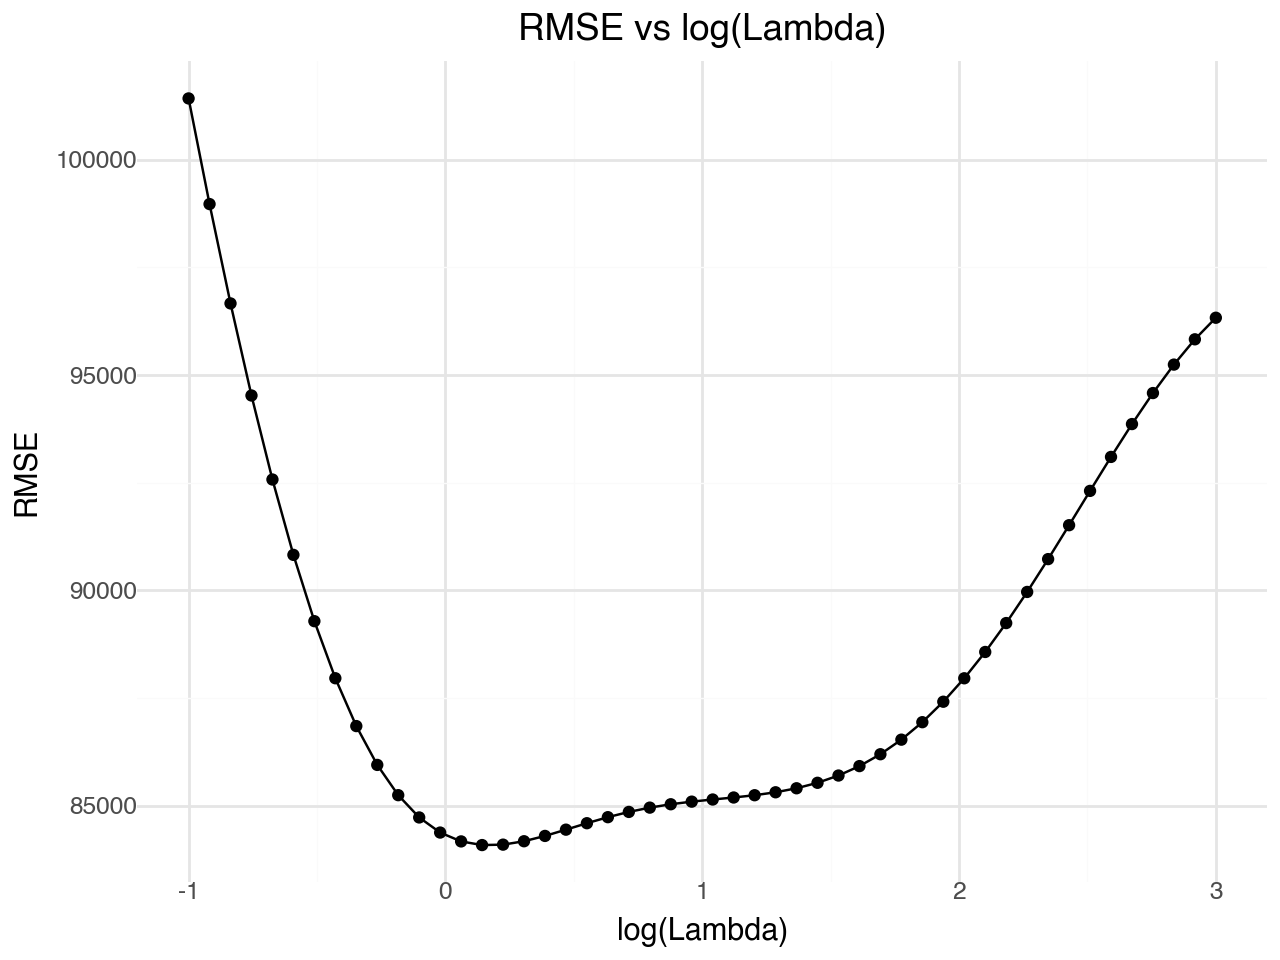

In [179]:
df_rmse = pd.DataFrame({
    'lambda': lambda_range,
    'log_lambda': np.log10(lambda_range),
    'rmse': rmse_list
})

plot = (
    p9.ggplot(df_rmse, p9.aes(x='log_lambda', y='rmse'))
    + p9.geom_line()
    + p9.geom_point(size=1.5)
    + p9.labs(
        title='RMSE vs log(Lambda)',
        x='log(Lambda)',
        y='RMSE'
    )
    + p9.theme_minimal()
)

plot

In [136]:
df_rmse['rmse'].min()

np.float64(34319.06207064528)

## 3. Testing Data

In [137]:
X_test, y_test = recenter(X_test, y_test)
beta_hat_test = ridge(X_train, y_train, fLambda=152)

feat_list = list(X_raw[0].keys())
feat = np.array(feat_list)
beta_hat_test_labeled = np.column_stack((feat, beta_hat_test))
np.savetxt("data/beta_hat_test_labeled.csv", beta_hat_test_labeled, fmt="%s", delimiter=",")

y_hat_test = predict(X_test, beta_hat_test)
mse_test = mean_squared_error(y_hat_test, y_test)
rmse_test = np.sqrt(mse_test)
print('MSE in sample:', mse_test)
print('RMSE in sample:', rmse_test)

MSE in sample: 7961457320.152759
RMSE in sample: 89226.99882968584
